In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt


from collections import namedtuple

from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.activations import relu
from keras.layers import Input, Dense, Embedding, Flatten, Conv1D, MaxPooling1D
from keras.layers import Dropout, concatenate


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/SST1/convnets_utils.py /content

In [ ]:
# Stanford Sentiment Treebank - movie reviews with fine-grained labels
# https://nlp.stanford.edu/sentiment/

ST_sentence = namedtuple("Stanford_Sentiment", "id sentence")
ST_score = namedtuple("Stanford_Sentiment", "id score")

sentences = dict()
scores = dict()
train = []
dev = []
test = []

for filename in ['datasetSentences.txt','datasetSplit.txt', 'sentiment_labels.txt']:
    with open("/content/drive/MyDrive/SST1/ST/"+filename,'r') as f_input:
        for line in f_input:

            # skip headers
            if line.startswith("sentence_index") or line.startswith('phrase id'):
                continue

            # load sentences
            if filename=='datasetSentences.txt':
                sent_id, sentence = line.split('\t', 1)
                sentences[sent_id] = sentence.strip()

            # load splits
            if filename=='datasetSplit.txt':
                sent_id, split = line.split(',', 1)
                split = int(split.strip())
                if split == 1:
                    train.append(sent_id)
                if split == 2:
                    test.append(sent_id)
                if split == 3:
                    dev.append(sent_id)

            # sentences_id
            if filename=='sentiment_labels.txt':
                sent_id, sent_score = line.split('|', 1)
                #sent_score = float(sent_score.strip())
                sample = ST_score(sent_id, float(sent_score.strip()))
                scores[sent_id] = sent_score.strip()

In [ ]:
print("Total Nr. Samples: {}".format(len(sentences)))
print("Total Nr. Scores : {}".format(len(scores)))
print()
print("Train  : {}".format(len(train)))
print("Dev    : {}".format(len(dev)))
print("Test   : {}".format(len(test)))


Total Nr. Samples: 11855
Total Nr. Scores : 239232

Train  : 8544
Dev    : 1101
Test   : 2210


In [ ]:
# built two lists with sentences and labels
x_train_data = [sentences[x] for x in train]
y_train_data = [scores[x] for x in train]

x_dev_data = [sentences[x] for x in dev]
y_dev_data = [scores[x] for x in dev]

x_test_data = [sentences[x] for x in test]
y_test_data = [scores[x] for x in test]


In [ ]:
# convert list of tokens/words to indexes
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_data)
sequences_train = tokenizer.texts_to_sequences(x_train_data)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 15337 unique tokens.


In [ ]:
# get the max sentence lenght, needed for padding
max_input_length = max([len(x) for x in sequences_train])
max_input_length

49

In [ ]:
# pad all the sequences of indexes to the 'max_input_lenght'
x_train_data_padded = pad_sequences(sequences_train, maxlen=max_input_length, padding='post', truncating='post')
x_dev_data_padded = pad_sequences(tokenizer.texts_to_sequences(x_dev_data), maxlen=max_input_length, padding='post', truncating='post')
x_test_data_padded = pad_sequences(tokenizer.texts_to_sequences(x_test_data), maxlen=max_input_length, padding='post', truncating='post')

In [ ]:
def convert_to_categories(y_data):
    y_categories = []
    for score in y_data:
        if 0.0<=float(score)<0.2:
            y_categories.append('very_negative')
        elif 0.2<=float(score)<0.4:
            y_categories.append('negative')
        elif 0.4<=float(score)<0.6:
            y_categories.append('neutral')
        elif 0.6<=float(score)<0.8:
            y_categories.append('positive')
        elif 0.8<=float(score)<=1.0:
            y_categories.append('very positive')

    return y_categories

In [ ]:
# Convert from scores to categories
y_train_data_categ = convert_to_categories(y_train_data)
y_dev_data_categ = convert_to_categories(y_dev_data)
y_test_data_categ = convert_to_categories(y_test_data)

# Encode the labels, each must be a vector with dim = num. of possible labels
le = LabelEncoder()
le.fit(y_train_data_categ)

labels_encoded_train = le.transform(y_train_data_categ)
labels_encoded_dev = le.transform(y_dev_data_categ)
labels_encoded_test = le.transform(y_test_data_categ)

categorical_labels_train = to_categorical(labels_encoded_train, num_classes=None)
categorical_labels_dev = to_categorical(labels_encoded_dev, num_classes=None)
categorical_labels_test = to_categorical(labels_encoded_test, num_classes=None)

In [ ]:
print(x_train_data_padded.shape)
print(categorical_labels_train.shape)

(8544, 49)
(8544, 5)


In [ ]:
print(x_dev_data_padded.shape)
print(categorical_labels_dev.shape)

(1101, 49)
(1101, 5)


In [ ]:
print(x_test_data_padded.shape)
print(categorical_labels_test.shape)

(2210, 49)
(2210, 5)


In [ ]:
def load_fasttext_embeddings():
    glove_dir = '/content/drive/MyDrive/SST1/Glove.6B'
    embeddings_index = {}
    f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index

def create_embeddings_matrix(embeddings_index, vocabulary, embedding_dim=100):
    embeddings_matrix = np.random.rand(len(vocabulary) + 1, embedding_dim)
    for i, word in enumerate(vocabulary):
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector
    print('Matrix shape: {}'.format(embeddings_matrix.shape))
    return embeddings_matrix


def get_embeddings_layer(embeddings_matrix, name, max_len, trainable=False):
    embedding_layer = Embedding(
        input_dim=embeddings_matrix.shape[0],
        output_dim=embeddings_matrix.shape[1],
        input_length=max_len,
        weights=[embeddings_matrix],
        trainable=trainable,
        name=name)
    return embedding_layer

def get_conv_pool(x_input, max_len, suffix, n_grams=[3, 4, 5], feature_maps=100):
    branches = []
    for n in n_grams:
        branch = Conv1D(filters=feature_maps, kernel_size=n, activation=relu,
                        name='Conv_' + suffix + '_' + str(n))(x_input)
        branch = MaxPooling1D(pool_size=max_len - n + 1, strides=None, padding='valid',
                              name='MaxPooling_' + suffix + '_' + str(n))(branch)
        branch = Flatten(name='Flatten_' + suffix + '_' + str(n))(branch)
        branches.append(branch)
    return branches

def get_cnn_pre_trained_embeddings(embedding_layer, max_len, num_classes,
                                   loss='categorical_crossentropy'):
    # connect the input with the embedding layer
    i = Input(shape=(max_len,), dtype='int32', name='main_input')
    x = embedding_layer(i)

    # generate several branches in the network, each for a different convolution+pooling operation,
    # and concatenate the result of each branch into a single vector
    branches = get_conv_pool(x, max_len, 'static')
    z = concatenate(branches, axis=-1)
    z = Dropout(0.5)(z)

    # pass the concatenated vector to the prediction layer
    o = Dense(num_classes, activation='softmax', name='output')(z)

    model = Model(inputs=i, outputs=o)
    model.compile(loss={'output': loss}, optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
embeddings_index = load_fasttext_embeddings()
embeddings_matrix = create_embeddings_matrix(embeddings_index, word_index, 100)

embedding_layer_static = get_embeddings_layer(embeddings_matrix,
                                              'embedding_layer_static',
                                              max_input_length,
                                              trainable=False)

model_2 = get_cnn_pre_trained_embeddings(embedding_layer_static, max_input_length, 5,
                                         loss='categorical_crossentropy')

Loaded 400000 word vectors.
Matrix shape: (15338, 100)


In [ ]:
history = model_2.fit(x=x_train_data_padded,
                      validation_data=(x_dev_data_padded, categorical_labels_dev),
                      y=categorical_labels_train, batch_size=50, epochs=10)

Epoch 1/10
171/171 [==============================] - 9s 47ms/step - loss: 1.4455 - accuracy: 0.4774 - val_loss: 1.4287 - val_accuracy: 0.4578
Epoch 2/10
171/171 [==============================] - 7s 42ms/step - loss: 1.2549 - accuracy: 0.5309 - val_loss: 1.4109 - val_accuracy: 0.4569
Epoch 3/10
171/171 [==============================] - 7s 42ms/step - loss: 1.2051 - accuracy: 0.5437 - val_loss: 1.4122 - val_accuracy: 0.4559
Epoch 4/10
171/171 [==============================] - 7s 43ms/step - loss: 1.1452 - accuracy: 0.5638 - val_loss: 1.4475 - val_accuracy: 0.4559
Epoch 5/10
171/171 [==============================] - 7s 43ms/step - loss: 1.0834 - accuracy: 0.5825 - val_loss: 1.4551 - val_accuracy: 0.4559
Epoch 6/10
171/171 [==============================] - 7s 42ms/step - loss: 1.0233 - accuracy: 0.6122 - val_loss: 1.5324 - val_accuracy: 0.4559
Epoch 7/10
171/171 [==============================] - 7s 42ms/step - loss: 0.9560 - accuracy: 0.6380 - val_loss: 1.4950 - val_accuracy: 0.4514

In [ ]:
loss, accuracy = model_2.evaluate(x_test_data_padded, categorical_labels_test, verbose=0)
accuracy

0.48914027214050293

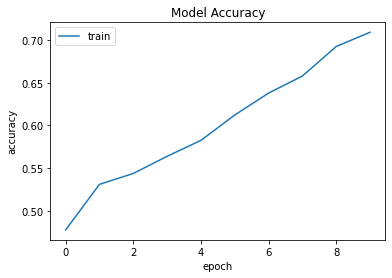

In [ ]:
plt.plot(history.history['accuracy'])

plt.title("Model Accuracy")

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['train'], loc='upper left')

plt.show()

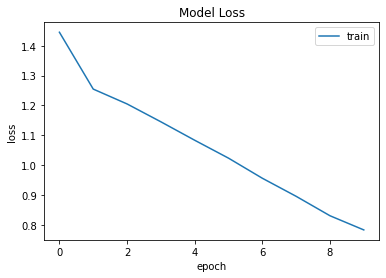

In [ ]:
plt.plot(history.history['loss'])

plt.title("Model Loss")

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['train'], loc='upper right')

plt.show()

In [ ]:
raw_predictions = model_2.predict(x_test_data_padded)
class_predictions = [np.argmax(x) for x in raw_predictions]
print(classification_report(y_test_data_categ, le.inverse_transform(class_predictions)))


70/70 [==============================] - 1s 11ms/step
               precision    recall  f1-score   support

     negative       0.17      0.05      0.08       405
      neutral       0.52      0.90      0.66      1155
     positive       0.26      0.05      0.09       424
very positive       0.20      0.01      0.02       112
very_negative       0.00      0.00      0.00       114

     accuracy                           0.49      2210
    macro avg       0.23      0.20      0.17      2210
 weighted avg       0.36      0.49      0.38      2210



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
